In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
import category_encoders as ce
from category_encoders import WOEEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
from sklearn.preprocessing import RobustScaler

In [4]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder

In [5]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


In [6]:
df = pd.read_csv('clean_data.csv')

In [7]:
pd.options.display.max_columns=100

In [8]:
df.drop(columns=['Unnamed: 0','funder','installer','construction_year'],inplace=True )

In [9]:
df1 = df.copy()

In [10]:
df1.drop(columns=['lga','ward'],inplace=True )

In [11]:
df1['permit'] = df1['permit'].astype(bool).astype(int)

In [12]:
df1['public_meeting'] = df1['public_meeting'].astype(bool).astype(int)

In [13]:
cat_col = ['basin','region','extraction_type_group','management','payment','water_quality','quantity',
               'source','waterpoint_type','decade','installer_cat','funder_cat']

In [14]:
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']

In [15]:
target_status_group = {0:0, 1: 1, 2 : 0}
df1['status_group'] = df1['status_group'].replace(target_status_group)

In [16]:
df1['status_group'].value_counts()

0    36576
1    22824
Name: status_group, dtype: int64

In [18]:
target='status_group'

In [19]:
encoder = TargetEncoder()
# #     encoder = LeaveOneOutEncoder()


for c in cat_col:
    df1[str(c) + '_encoded'] = encoder.fit_transform(df1[c].values, df[target])
    df1.drop(columns=c, inplace=True) # TRAINING SET
    
# scaler = RobustScaler()

# encoder = ce.WOEEncoder(cols=cat_col)

# following steps will try later on to improve 
# Creating the separate transformers for numeric and categorical columns
# num_transformer = make_pipeline(scaler)
# cat_transformer = make_pipeline(encoder)

# # Defining preprocessor, which combines the two transformers
# preprocessor = ColumnTransformer(
#     transformers=[('num', num_transformer, num_col),
#                   ('cat', cat_transformer, cat_col)])

In [21]:
used_cols = [c for c in df1.columns.tolist() if c not in [target]]
X=df1[used_cols]
y=df1[target]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

TRAIN accuracy: 0.7332281144781144
TEST accuracy: 0.7282828282828283


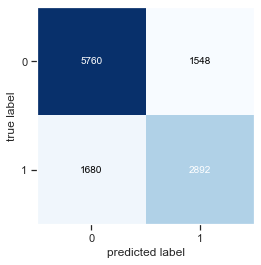

In [23]:
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

pipe = make_pipeline(lr)
pipe.fit(X_train, y_train)


# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_score = pipe.predict(X_test)

print("TRAIN accuracy:",accuracy_score(y_train, y_pred))
print("TEST accuracy:",accuracy_score(y_test, y_score))

cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()